# Lab 3

## Imports

In [1]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import download as nltk_download

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

## TASK 3. Recurrent neural networks (from scratch)

Dataset: [https://web.archive.org/web/20200616205636/http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/smsspamcollection.zip](https://web.archive.org/web/20200616205636/http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/smsspamcollection.zip)

### Reading data (append column names)

In [2]:
with open('./SMSSpamCollection.txt', 'r', encoding="utf-8") as f:
    original_dataset = f.read()

with open('./sms_spam_collection.txt', 'w', encoding="utf-8") as f:
    f.write('type\tmessage\n' + original_dataset)
    
data = pd.read_csv("./sms_spam_collection.txt", sep='\t')
data.head()

,type,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Clean messages

In [3]:
nltk_download('stopwords')
stop_words = stopwords.words("english")

def clean_text(text):
    text = text.lower()
    text = re.sub(r"@\S+", " ", text)
    text = re.sub(r"https*\S+", " ", text)
    text = re.sub(r"http*\S+", " ", text)
    text = re.sub(r"#\S+", " ", text)
    text = re.sub(r"\d", " ", text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s{2,}',' ', text)
    text = text.replace('>', ' ')
    text = text.replace('<', ' ')
    text = text.replace('&lt', ' ')
    text = text.replace('&lt', ' ')
    text = text.replace('=', ' ')
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data['message'] = data['message'].apply(clean_text)

### Tokenize texts

In [5]:
X = data['message']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['type'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [7]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

### Build model

In [8]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train_pad, 
    y_train, 
    epochs=5, 
    batch_size=32, 
    validation_data=(X_test_pad, y_test)
)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8762 - loss: 0.3223 - val_accuracy: 0.9776 - val_loss: 0.0776
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9878 - loss: 0.0423 - val_accuracy: 0.9821 - val_loss: 0.0562
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9949 - loss: 0.0203 - val_accuracy: 0.9874 - val_loss: 0.0643
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9986 - loss: 0.0060 - val_accuracy: 0.9874 - val_loss: 0.0818
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9980 - loss: 0.0036 - val_accuracy: 0.9874 - val_loss: 0.0653


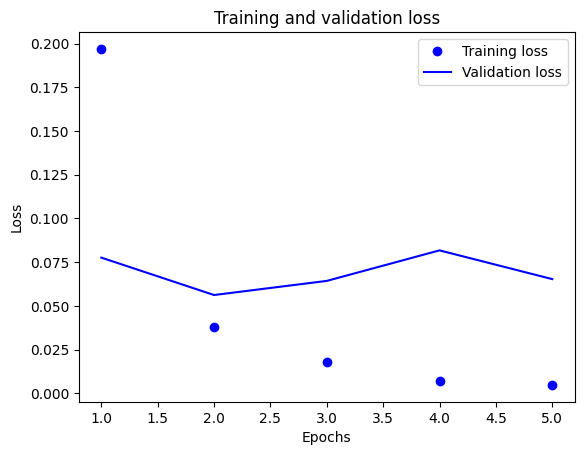

In [10]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
score = model.evaluate(X_test_pad, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.06533300876617432
Test accuracy: 0.9874439239501953


## TASK 3. Recurrent neural networks (pretrained word embeddings)

> Download https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

### Text vectorization

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [13]:
vectorizer = layers.TextVectorization(max_tokens=5000, output_sequence_length=100)
vectorizer.adapt(X_train)

In [14]:
X_train_vec = vectorizer(X_train)
X_test_vec = vectorizer(X_test)

In [15]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [16]:
path_to_glove_file = "glove.6B/glove.6B.100d.txt"

In [17]:
embeddings_index = {}
with open(path_to_glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [18]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4262 words (738 misses)


In [19]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

### Build the model

In [20]:
num_classes = 5
int_sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 3, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation="relu")(x)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, None, 100)           │         500,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, None, 128)           │          38,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, None, 128)           │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, None, 128)           │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 654,445 (2.50 MB)

 Trainable params: 154,245 (602.52 KB)

 Non-trainable params: 500,200 (1.91 MB)

### Train the model

In [21]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])

In [22]:
history = model.fit(
    X_train_vec, 
    y_train, 
    batch_size=128, 
    epochs=8, 
    validation_data=(X_test_vec, y_test),
    verbose=1
)

Epoch 1/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.8035 - loss: 0.5990 - val_acc: 0.9596 - val_loss: 0.1385
Epoch 2/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9588 - loss: 0.1277 - val_acc: 0.9740 - val_loss: 0.0959
Epoch 3/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.9731 - loss: 0.0847 - val_acc: 0.9740 - val_loss: 0.1017
Epoch 4/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9748 - loss: 0.0928 - val_acc: 0.9767 - val_loss: 0.0938
Epoch 5/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9877 - loss: 0.0480 - val_acc: 0.9812 - val_loss: 0.0861
Epoch 6/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9892 - loss: 0.0389 - val_acc: 0.9821 - val_loss: 0.0720
Epoch 7/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9968 - loss: 0.0176 - val_acc: 0.9767 - val_loss: 0.1197
Epoch 8/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9950 - loss: 0.0257 - val_acc: 0.9857 - val_loss: 0.0797


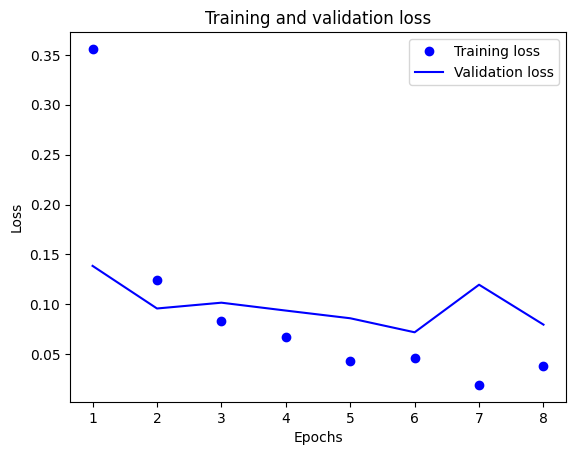

In [23]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
score = model.evaluate(X_test_vec, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.07966040074825287
Test accuracy: 0.9856502413749695


> The results obtained using recurrent neural networks are much better than those obtained in Lab Work 2, where Naive Bayes, AdaBoost, Random Forest, Decision Tree, SVM, and k-NN were used, with the highest accuracy being 97% (SVM).
When using recurrent neural networks, even when implementing the model from scratch without excessive effort, a result of nearly 99% was achieved.
Using pretrained word embeddings allowed for faster training, but in my opinion, the real significant result will be visible on larger datasets, not on a small one like mine. Therefore, using pretrained word embeddings, the result was almost the same as from scratch.